# Table of Contents
## Part 1: Reading and Merging Data Sources
## Part 2: Train (using Naive Bayes)
## Part 3: Test

# Part 1: Reading and Merging Data Sources]


## Data source:
**https://www.kaggle.com/datasnaek/youtube-new**

## Import Modules

In [20]:

import numpy as np
import pandas as pd
import collections
import seaborn as sbn 
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Import the CSV and take an initial look:

In [21]:
USvids = pd.read_excel("USvideos.xlsx", header=0)
USvids.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ��������� \n\nSUBSCRIB...


## Delete unused columns and rename the remaining columns:

In [22]:
keep_columns = ['title','category_id']
new_USvids = USvids[keep_columns]
new_USvids.to_csv("newUS.csv", index=False)
new_USvids = pd.read_csv("newUS.csv", header=0, names=['Title','Category_ID'])

## The data source provided descriptions of Category_ID in a seperate JSON file
## Let's look at the JSON file:

In [23]:
Categories_JSON = pd.read_json("US_category_id.JSON")
Categories_JSON.head(3)

,kind,etag,items
0,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
1,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
2,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."


## Create a list of dictionaries with ID and Category label mapping:

In [24]:
CategoryDict = [{'id': item['id'], 'title': item['snippet']['title']} for item in Categories_JSON['items']]

## Create a data frame of the above information

In [25]:
CategoriesDF = pd.DataFrame(CategoryDict)
Categories = CategoriesDF.rename(index=str, columns={"id": "Category_ID", "title": "Category"})
Categories.head(3)

,Category_ID,Category
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music


# Part 2: Train (using Naive Bayes)

## Split 'Title' into a string of words using CountVectorizer:

In [26]:
vector = CountVectorizer()
counts = vector.fit_transform(new_USvids['Title'].values)

## Use the naive Bayes model and target 'Category':

In [27]:
NB_Model = MultinomialNB()
targets = new_USvids['Category_ID'].values
NB_Model.fit(counts,targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Check Accuracy using a 90/10 train/test split

In [28]:

X= counts
y= targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1)

NBtest = MultinomialNB().fit(X_train, y_train)
nb_predictions = NBtest.predict(X_test)
acc_nb = NBtest.score(X_test, y_test)
print('The Naive Bayes Algorithm scored an accuracy of', acc_nb)

The Naive Bayes Algorithm scored an accuracy of 0.8976800976800977


## Satisfactory accuracy, training using Historical Data is complete.

# Part 3: Test

## Enter hypothetical titles to predict the category for:

In [29]:

Titles = ["Hilarious cat plays with toy",
        "Best fashion looks for Spring 2018",
        "Olympics opening ceremony highlights",
        "Warriors basketball game versus the cavs",
        "CNN world news on donald trump",
        "Police Chase in Hollywood",
        "Ed Sheeran - Perfect (Official Music Video)",
        "how to do eyeshadow",
        "Call of Duty"
         ]

## Insert said titles into naive Bayes model:

In [30]:

Titles_counts = vector.transform(Titles)
Predict = NB_Model.predict(Titles_counts)
Predict

array([24, 24, 17, 17, 25, 26, 10, 26, 20], dtype=int64)

## Output will be an array of numbers. Iterate through the Category Dictionary (from JSON file) to find "title":

In [31]:
CategoryNamesList = []
for Category_ID in Predict:
    MatchingCategories = [x for x in CategoryDict if x["id"] == str(Category_ID)]
    if MatchingCategories:
        CategoryNamesList.append(MatchingCategories[0]["title"])

## Map these values to the Titles we want to Predict:

In [32]:
TitleDataFrame = []
for i in range(0, len(Titles)):
    TitleToCategories = {'Category': CategoryNamesList[i], 'Title': Titles[i]}
    TitleDataFrame.append(TitleToCategories)

## Convert the resulting Dict to a Data Frame:

In [33]:
PredictDF = pd.DataFrame(Predict)
TitleDF = pd.DataFrame(TitleDataFrame)
PreFinalDF = pd.concat([PredictDF, TitleDF], axis=1)
PreFinalDF.columns = (['Categ_ID', 'Predicted Category', 'Hypothetical Video Title'])
FinalDF = PreFinalDF.drop(['Categ_ID'],axis=1)
cols = FinalDF.columns.tolist()
cols = cols[-1:] + cols[:-1]
FinalDF= FinalDF[cols]

# View Final Prediction Results:

In [34]:
FinalDF

,Hypothetical Video Title,Predicted Category
0,Hilarious cat plays with toy,Entertainment
1,Best fashion looks for Spring 2018,Entertainment
2,Olympics opening ceremony highlights,Sports
3,Warriors basketball game versus the cavs,Sports
4,CNN world news on donald trump,News & Politics
5,Police Chase in Hollywood,Howto & Style
6,Ed Sheeran - Perfect (Official Music Video),Music
7,how to do eyeshadow,Howto & Style
8,Call of Duty,Gaming


## Confusion Matrix

In [36]:
cnf_mat = confusion_matrix(y_test, nb_predictions)
print(cnf_mat)

[[226   0   6   1   0   0   0   2   2   7   1   2   0   2   0   0]
 [  0  29   0   0   0   0   0   1   0   1   0   0   0   3   0   0]
 [  1   0 635   0   1   0   0   1   2  15   3   2   0   1   0   0]
 [  0   0   0  90   0   0   0   3   2   5   2   2   0   1   0   0]
 [  0   0   1   0 194   1   0   0   0   3   2   0   1   2   0   0]
 [  0   0   0   0   0  46   0   0   2   0   0   1   0   0   0   0]
 [  1   0   0   0   3   0  65   0   0   5   0   1   0   0   0   0]
 [  1   0   9   0   2   0   0 252  12  15   0  17   2   7   0   0]
 [  0   0   8   0   4   0   0   7 287  20   7   6   2   2   0   0]
 [ 10   5  30   1   3   0   1   9   5 877  11  29   5  12   0   0]
 [  0   0   0   0   2   0   0   1   4   4 231   2   2   3   0   0]
 [  0   0   1   1   4   0   0   7   1  12   1 367   1   4   0   0]
 [  0   0   0   0   1   0   0   0   1   2   0   2 166   2   0   0]
 [  2   1   3   0   0   0   0   5   1   4   1   2   2 208   0   0]
 [  0   0   0   0   0   0   0   0   0   4   0   0   1   0   0 

## Plotting Confusion Matrix

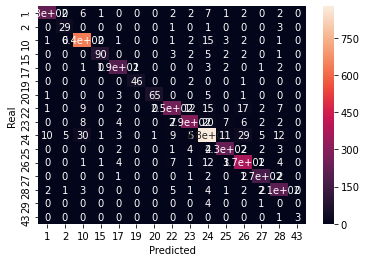

In [37]:
cnf_mat = pd.crosstab(y_test, nb_predictions, rownames=['Real'], colnames=['Predicted'])
sbn.heatmap(cnf_mat,annot=True)

## All numeric (float and int) variables in the dataset

In [38]:

yt_numeric = USvids.select_dtypes(include=['float64', 'int64'])
yt_numeric.head()

,category_id,views,likes,dislikes,comment_count
0,22,748374,57527,2966,15954
1,24,2418783,97185,6146,12703
2,23,3191434,146033,5339,8181
3,24,343168,10172,666,2146
4,24,2095731,132235,1989,17518


## Correlation matrix

In [39]:
mat = yt_numeric.corr()
mat

,category_id,views,likes,dislikes,comment_count
category_id,1.000000,-0.168231,-0.173921,-0.033547,-0.076307
views,-0.168231,1.000000,0.849177,0.472213,0.617621
likes,-0.173921,0.849177,1.000000,0.447186,0.803057
dislikes,-0.033547,0.472213,0.447186,1.000000,0.700184
comment_count,-0.076307,0.617621,0.803057,0.700184,1.000000


## Plotting Correlation matrix

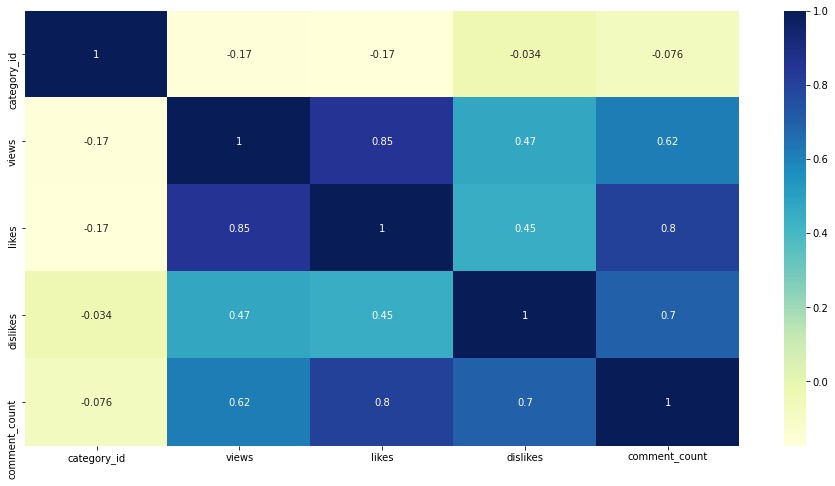

In [40]:
# Figure size
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16,8))

# Heatmap
sns.heatmap(mat, cmap="YlGnBu", annot=True)
plt.show()